In [1]:
from gt3x_loader import GT3XReader
import matplotlib.pyplot as plt
from numba import jit
import numpy as np

In [2]:
def cal_mad(data, points):
    """
    Calculate MAD values. (by Johannes Zschocke)
    This routine calculates the MAD values based on the number of points
    (given by points) on the given 3D data.
    Parameters
    ----------
    data : 3D numpy array
        contains 3D data.
    points : integer
        number of datapoints to use for mad calculation.
    Returns
    -------
    mad : numpy array
        contains the calculated mad values.
    """
    # 'allocate' arrays and variables
    # the following variables are used as described and introduced by VahaYpya
    # 2015 DOI: 10.1111/cpf.12127

    # array for mad values
    mad = np.zeros(int(len(data[0]) / points))
    print(mad.shape)

    # array for r_i values
    r_i_array = np.empty(points)
    r_i_array[:] = np.nan

    # R_ave value
    R_ave = 0
    i_mad = 0

    # iterate over all values in data
    i = 0
    for (x, y, z) in zip(data[0], data[1], data[2]):
        r_i = np.sqrt(x**2 + y**2 + z**2)
        r_i_array[i] = r_i
        i += 1
        if (i == points):
            R_ave = np.nanmean(r_i_array)
            s = 0
            for ri in r_i_array:
                s += np.abs(ri - R_ave)

            s = s / points
            mad[i_mad] = s
            i_mad += 1
            r_i_array[:] = np.nan
            i = 0

    return mad


cal_mad_jit = jit(cal_mad)

In [3]:
# load gt3x data
gt3x_data = GT3XReader(r"./10383.gt3x")
# get acc, shape is (n, 3) (X, Y, Z)
acc = gt3x_data.get_signal('activity')
# get lux
lux = gt3x_data.get_signal('lux')
mad = cal_mad_jit(acc.T, gt3x_data.sample_rate)

(653834,)


In [4]:
gt3x_data.signalnames()

['metadata', 'parameters', 'activity', 'lux', 'battery']

In [5]:
gt3x_data.file_info

{'Serial Number': ' CLE1B51120173',
 'Device Type': ' GT3XPlus',
 'Firmware': ' 2.3.0',
 'Battery Voltage': ' 3,4',
 'Sample Rate': 100,
 'Start Date': datetime.datetime(2015, 4, 28, 10, 21),
 'Stop Date': datetime.datetime(2015, 5, 5, 23, 59),
 'Last Sample Time': datetime.datetime(2015, 5, 5, 23, 59),
 'TimeZone': ' 02:00:00',
 'Download Date': ' 633032064780000000',
 'Board Revision': ' 1',
 'Unexpected Resets': ' 0',
 'Acceleration Scale': 341.0,
 'Acceleration Min': -6.0,
 'Acceleration Max': 6.0,
 'Sex': ' Female',
 'Height': ' 169,1',
 'Mass': ' 76,2',
 'Race': ' White / Caucasian',
 'Limb': ' Waist',
 'Side': ' Right',
 'Dominance': ' Dominant',
 'DateOfBirth': datetime.datetime(1977, 5, 5, 13, 0),
 'Subject Name': ' 2125030886',
 'Age': None}

Text(0.5, 0, 'Time')

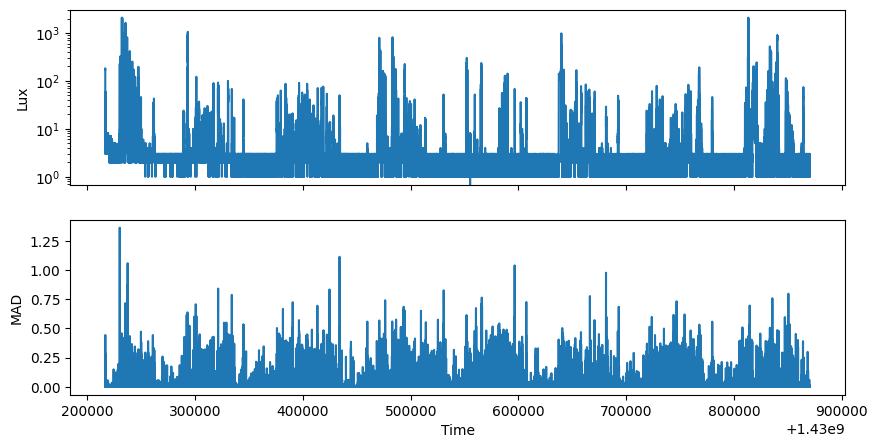

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
ax[0].plot(gt3x_data.times[5], lux)
ax[0].set_yscale('log')
ax[0].set_ylabel('Lux')
ax[1].plot(gt3x_data.times[0][:mad.size], mad)
ax[1].set_ylabel('MAD')
ax[1].set_xlabel("Time")